# Spot Hero Paid Search Effectiveness 

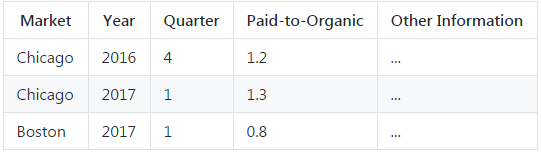

In [8]:
from IPython.display import Image
Image(filename = 'Capture.png', width=450, height=350)

## Paid Search Predictive Model Training

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#enable IPython to display matplotlib graphs
%matplotlib inline
import csv

In [415]:
#read in training data set
data=pd.read_csv('spothero_ds_takehome.csv')
data.head(10)
data.shape

(215235, 23)

In [268]:
data.columns

Index(['reservation_id', 'is_first_purchase', 'rental_source',
       'rental_source_operating_system', 'reservation_event_id',
       'discount_promocode_redemption_id', 'reservation_status',
       'cancellation_reason', 'discount_promocode_campaign_channel', 'market',
       'facility_id', 'facility_height_restriction', 'facility_type',
       'user_id', 'user_email_suffix', 'user_signup_source',
       'user_signup_timestamp', 'user_referral_credit_confirmed', 'survey_id',
       'survey_response', 'survey_user_text', 'google_analytics_id',
       'google_analytics_medium'],
      dtype='object')

In [269]:
data['google_analytics_medium'].value_counts()
#numeric variables: none (really? maybe 'facility_height_restriction', consider recode into bins)
#categorical variables with levels > 10: 'rental_source_operating_system', 'facility_height_restriction', 
#'user_email_suffix', 'cancellation_reason','discount_promocode_redemption_id','market', 'survey_response', 'survey_user_text', google_analytics_medium'
#consider recode to reduce dimension for categorical variables with level > 10

organic                    73461
cpc                        62913
(none)                     47524
referral                   21480
email                       3740
desktopweb                  1887
Website                     1319
iosapp                      1137
website                      779
androidapp                   405
partnerships                 274
Partnerships                 123
partner                       72
(not set)                     33
desktop                       33
display                       14
Online                         7
mobile                         7
operator page                  6
social                         5
Email                          3
tablet                         3
Account                        2
Chat                           2
Facebook                       2
soldier-field                  1
partners                       1
Address: 200 W Adams St        1
affiliate                      1
Name: google_analytics_medium, dtype: int64

In [270]:
#rows with missing value check:
data.shape #(215235, 23)
nan_rows = lambda df: df[df.isnull().any(axis=1)]
nan_rows(data).shape #all rows have NaNs

(215235, 23)

In [271]:
#colomns with missing value check:
nan_cols = lambda df: df.columns[df.isnull().any()].tolist()
nan_cols(data)

['reservation_event_id',
 'discount_promocode_redemption_id',
 'cancellation_reason',
 'discount_promocode_campaign_channel',
 'facility_height_restriction',
 'facility_type',
 'user_referral_credit_confirmed',
 'survey_id',
 'survey_response',
 'survey_user_text']

## Label Creation for Classification

In [273]:
data['google_analytics_medium'].value_counts()

organic                    73461
cpc                        62913
(none)                     47524
referral                   21480
email                       3740
desktopweb                  1887
Website                     1319
iosapp                      1137
website                      779
androidapp                   405
partnerships                 274
Partnerships                 123
partner                       72
(not set)                     33
desktop                       33
display                       14
Online                         7
mobile                         7
operator page                  6
social                         5
Email                          3
tablet                         3
Account                        2
Chat                           2
Facebook                       2
soldier-field                  1
partners                       1
Address: 200 W Adams St        1
affiliate                      1
Name: google_analytics_medium, dtype: int64

In [274]:
#create response label: 1 if 'google_analytics_medium' == 'cpc', 0 otherwise
data['label']=np.nan
data.loc[data['google_analytics_medium']=='cpc', 'label']=1
data.loc[data['label'].isnull(),'label']=0
data['label'].value_counts()
#data['label'].isnull().value_counts() #cleared

0.0    152322
1.0     62913
Name: label, dtype: int64

# Feature Engineering

columns = ['reservation_id', 'is_first_purchase', 'rental_source',
       'rental_source_operating_system', 'reservation_event_id',
       'discount_promocode_redemption_id', 'reservation_status',
       'cancellation_reason', 'discount_promocode_campaign_channel', 'market',
       'facility_id', 'facility_height_restriction', 'facility_type',
       'user_id', 'user_email_suffix', 'user_signup_source',
       'user_signup_timestamp', 'user_referral_credit_confirmed', 'survey_id',
       'survey_response', 'survey_user_text', 'google_analytics_id',
       'google_analytics_medium']
       
columns with missing values: ['reservation_event_id',
 'discount_promocode_redemption_id',
 'cancellation_reason',
 'discount_promocode_campaign_channel',
 'facility_height_restriction',
 'facility_type',
 'user_referral_credit_confirmed',
 'survey_id',
 'survey_response',
 'survey_user_text']

## Missin Values Imputation & Reengineering

In [275]:
#1. create new binary variable 'for_event' from 'reservation_event_id' (1 for non empty fields, 0 for NaNs)
#replace 'reservation_event_id' with 'for_event' in the model:
data['for_event']=np.nan
data.loc[~data['reservation_event_id'].isnull(),'for_event']=1
data.loc[data['for_event']!=1,'for_event']=0
data['for_event'].value_counts()
#data['for_event'].isnull().value_counts() #all false, cleared

0.0    199699
1.0     15536
Name: for_event, dtype: int64

In [276]:
##2. create new binary variable 'has_promocode' from 'discount_promocode_redemption_id' indicating whether a promo code was used 
data['has_promocode']=np.nan
data.loc[~data['discount_promocode_redemption_id'].isnull(),'has_promocode']=1
data.loc[data['has_promocode']!=1,'has_promocode']=0
data['has_promocode'].value_counts()
#data['has_promocode'].isnull().value_counts() #all false, cleared

0.0    201295
1.0     13940
Name: has_promocode, dtype: int64

In [277]:
#replacy all missin value in 'cancellation_reason' with 'other'
#need to reduce dimension (extract factors) in the next section
data.loc[data['cancellation_reason'].isnull(),'cancellation_reason']='Other'
#data['cancellation_reason'].value_counts()
#data['cancellation_reason'].isnull().value_counts() #all false, cleared


In [278]:
#missing values in 'discount_promocode_campaign_channel' is highly associated with whether a promocode is used when reserving
data.loc[data[['discount_promocode_redemption_id','discount_promocode_campaign_channel']].isnull().all(axis=1),
         ['discount_promocode_redemption_id','discount_promocode_campaign_channel']].shape #(201295, 2)
#consider recoding all missing values into 'off campaign'
data['discount_promocode_campaign_channel'].value_counts() #201560 missing value
data.loc[data['discount_promocode_campaign_channel'].isnull(),'discount_promocode_campaign_channel']='off campaign'
#data['discount_promocode_campaign_channel'].isnull().value_counts() #all false, cleared

In [279]:
#impute missing values in 'facility_height_restriction' with mode value (80)
data['facility_height_restriction'].isnull().value_counts() #62995 missing values
#df.mode() returns a dataframe
data.loc[data['facility_height_restriction'].isnull(),
         'facility_height_restriction']=data['facility_height_restriction'].mode()[0]
data['facility_height_restriction'].isnull().value_counts() #cleared

False    215235
Name: facility_height_restriction, dtype: int64

In [280]:
#impute missing values in 'facility_type' with mode value 
data['facility_type'].value_counts() 
data['facility_type'].isnull().value_counts() #8570 missing values
data.loc[data['facility_type'].isnull(),'facility_type']=data['facility_type'].mode()[0]
#data['facility_type'].isnull().value_counts() #cleared

In [281]:
#impute missing values in 'user_referral_credit_confirmed' with 'f'
data['user_referral_credit_confirmed'].value_counts() 
data['user_referral_credit_confirmed'].isnull().value_counts() #63503 missing values
data.loc[data[ 'user_referral_credit_confirmed'].isnull(), 'user_referral_credit_confirmed']='f'
#data[ 'user_referral_credit_confirmed'].isnull().value_counts() #cleared

In [282]:
#created new binary variable 'took_survey' from 'survey_id' indicating whether the survey attached with reservation is taken
data['survey_id'].value_counts() 
data['survey_id'].isnull().value_counts() #197206 missing values
data['took_survey']=np.nan
data.loc[data['survey_id'].isnull(),'took_survey']=0
data.loc[~data['survey_id'].isnull(),'took_survey']=1
data['took_survey'].isnull().value_counts() #cleared
data['took_survey'].value_counts()

0.0    197206
1.0     18029
Name: took_survey, dtype: int64

In [284]:
#'survey_response' has missing values suspectively for users who declined survey. Impute with value 'General'.
#also, it seems like the 'survey_user_text' is user's actual typed-in answer to the question "where do you learn about SpotHero?", 
#and 'survey_response' is recoded version of 'survey_user_text' reduced into topics/themes.
#we will use 'survey_reponse' over 'survey_user_text' in the model
data['survey_response'].value_counts()
data['survey_response'].isnull().value_counts() #198543 missing values
data.loc[data['survey_response'].isnull(),'survey_response']='General'
data['survey_response'].isnull().value_counts() #cleared
data['survey_user_text'].isnull().value_counts()

True     213810
False      1425
Name: survey_user_text, dtype: int64

In [285]:
#write 1st version semi-processed dataset to local csv file:
data.to_csv("data1.csv", sep=',', header=True, index = False)
data.columns

Index(['reservation_id', 'is_first_purchase', 'rental_source',
       'rental_source_operating_system', 'reservation_event_id',
       'discount_promocode_redemption_id', 'reservation_status',
       'cancellation_reason', 'discount_promocode_campaign_channel', 'market',
       'facility_id', 'facility_height_restriction', 'facility_type',
       'user_id', 'user_email_suffix', 'user_signup_source',
       'user_signup_timestamp', 'user_referral_credit_confirmed', 'survey_id',
       'survey_response', 'survey_user_text', 'google_analytics_id',
       'google_analytics_medium', 'label', 'for_event', 'has_promocode',
       'took_survey'],
      dtype='object')

## Feature Recode & Reduction

1.  recode cancellation_reason into reduced number of levels:
    Change of Plans: match 'change of plans', 'change', 'Weather', 'Event Cancellation' 'Event Cancelled' 'cancelled' 'cancellation'
    Book by Mistake: match 'mistake'
    Lost: match 'Lost', 'lost','wrong garage', 'wrong', 'Wrong Garage'
    Reservation Update: match 'Reservation Update', 'Update', 'update'
    Location Closed: match 'Closed' 'Closure' 
    Supply Request: match 'supply request' 'Supply' 'Supply Request'
    Operation Error: 'Lot Full' 'Full' 'lot full' 'full' 'No Attendant Present' 'Vehicle Too Large' 'Attendant' 'Double Charged' 'Scanner' 'Not Accepted','Charged Extra', 'tow', 'towed','Operator'
    Test: 'Test' 'test' 'TEST'
    Fraud: 'fraud' 'Fraud','Fraudulent','fraudulent'

#counts=data['cancellation_reason'].value_counts() #returns a pandas Series
#counts=counts.to_frame().head(100)

In [286]:
#recode new binary variables from cancellatoin reasons indicating different reasons for cancelling reservation:

list_of_cancel_reasons = ['Book_by_Mistake','Lost','Reservation_Update', 'Location_Closed','Supply_Request', 'Operation_Error', 
                          'Testing', 'Fraud']
list_of_list_keywords = [('mistake', 'Mistake'),
                         ('Lost','lost', 'wrong','wrong garage', 'Wrong Garage', 'Wrong garage'),
                         ('Change', 'change','Weather', 'weather', 'Cancelled', 'cancelled','Cancellation', 'cancellation', 
                          'Update', 'update'),
                         ('Closed','closed','Closure','closure'),
                        ('Supply Request','Supply','supply request','supply'),
                        ('Full','full','No Attendant','no attendant','No attendant','Too Large','too large','Double Charged',
                         'double charged','Scanner','scanner','Not Accepted','not accepted','Not accepted',
                         'Charged Extra','charged extra', 'tow', 'Tow','Towed','towed','Operator','operator'),
                        ('Test','test','TEST','Testing','testing','TESTING'),
                        ('Fraud','fraud','Fraudulent','fraudulent')]
#loop to create new variables:
i=0
for reason in list_of_cancel_reasons:
    data[reason]=np.nan
    for keyword in list_of_list_keywords[i]:
        data.loc[data['cancellation_reason'].str.contains(keyword),reason]=1
    i=i+1

#fill in all the NaNs in new binary variables created above with 0
for reason in list_of_cancel_reasons:
    data.loc[data[reason].isnull(),reason]=0

In [287]:
#['Book_by_Mistake','Lost','Reservation_Update', 'Location_Closed','Supply_Request', 'Operation_Error', 'Testing', 'Fraud']
data['Book_by_Mistake'].value_counts()
nan_rows(data[list_of_cancel_reasons]) #zero rows return, cleared

,Book_by_Mistake,Lost,Reservation_Update,Location_Closed,Supply_Request,Operation_Error,Testing,Fraud


2. recode new binary variables from 'rental_source_operating_system' indicating operation systems at rental source:
Windows, iOS, Mac, Chrome, Linux, Ubuntu, Other
#data['rental_source_operating_system'].value_counts()

In [418]:
data['rental_source_operating_system'].value_counts()

Windows 7         53646
iOS               46744
Mac OS X          44562
Windows 10        21129
Android           19884
Windows 8.1       10732
Windows           10252
Chrome OS          2602
Windows Vista      2290
Windows XP         1890
Windows 8           749
Linux               288
Ubuntu              128
BlackBerry OS       116
Windows Phone       109
Windows RT 8.1       70
Fedora               30
Other                 6
Windows RT            6
FreeBSD               1
Solaris               1
Name: rental_source_operating_system, dtype: int64

In [288]:
list_of_operating_systems=['Windows','iOS','Mac','Chrome','Linux','Ubuntu']
list_of_keywords=['Windows','iOS','Mac','Chrome','Linux','Ubuntu']

#enter loop to create new variables
i=0
for system in list_of_operating_systems:
    data[system]=np.nan
    keyword=list_of_keywords[i]
    data.loc[data['rental_source_operating_system'].str.contains(keyword),system]=1
    i=i+1
    
#fill in all NaNs in newly created binary variables with 0:
for system in list_of_operating_systems:
    data.loc[data[system].isnull(),system]=0

In [289]:
#create variable 'Other_system' for rows where rental source system is not any in the list_of_operating_systems:
data['Other_system']=np.nan
sum_systems=data[list_of_operating_systems].sum(axis=1).to_frame()  #pd.sum() here returns a pandas Series
data.loc[sum_systems[0]==0, 'Other_system']=1
data.loc[data['Other_system'].isnull(), 'Other_system']=0

3. for 'discount_promocode_campaign_channel', recode to group all the levels with frequency count <100 into one level together with 'Other'
#data['discount_promocode_campaign_channel'].value_counts()

In [290]:
channel_to_group=['OOH - Billboards','Direct Mail','City Launch','Market Research','ApplePay']
for channel in channel_to_group:
    data.loc[data['discount_promocode_campaign_channel']==channel, 'discount_promocode_campaign_channel']='Other'

data['discount_promocode_campaign_channel'].value_counts()    

off campaign                   201560
Email                            3653
Site                             3052
Radio                            2143
Partnerships                     2106
Paid Search                       861
Other                             833
Social Media                      310
Business Partnerships             239
Deal Sites                        185
Employee Promo Codes              154
Hero Customer Service Codes       139
Name: discount_promocode_campaign_channel, dtype: int64

In [291]:
#4. recode 'market' to group all locations with frequency count <1000 into one level 'Other'
#could also consider recode into regions
freq=data['market'].value_counts().to_frame()
freq.reset_index(level=0, inplace=True)
list_of_markets=freq.loc[freq['market']<1000,'index'].tolist()
list_of_markets

['New Orleans',
 'Oakland',
 'Minneapolis',
 'Seattle',
 'Miami',
 'San Diego',
 'Austin',
 'Houston',
 'San Jose',
 'Indianapolis',
 'St. Louis',
 'Dallas',
 'Atlanta',
 'Orlando',
 'Sacramento',
 'Nashville',
 'Fort Lauderdale',
 'Detroit',
 'Jacksonville',
 'Tampa',
 'Monterey']

In [292]:
data['market2']=np.nan
for market in list_of_markets:
    data.loc[data['market'].str.contains(market),'market2']='Other'
data.loc[data['market2'].isnull(),'market2']=data['market']
data['market2'].value_counts()

Chicago          112654
New York          41632
Washington        20686
Boston            12635
San Francisco     11155
Other              4625
Los Angeles        2649
Philadelphia       2331
Denver             2126
Newark             1640
Baltimore          1561
Milwaukee          1541
Name: market2, dtype: int64

4. recode 'user_email_suffix' to group all levels other than gmail, yahoo, hotmail, aol, comcast into one level 'Other'
#data['user_email_suffix'].value_counts()

In [293]:
data['user_email']=np.nan
list_of_emails=['gmail.com','yahoo.com','hotmail.com','aol.com','comcast.net']
for email in list_of_emails:
    data.loc[data['user_email_suffix'].str.contains(email), 'user_email']=email
data.loc[data['user_email'].isnull(),'user_email']='Other'
data['user_email'].value_counts()

gmail.com      91967
Other          53358
yahoo.com      31886
hotmail.com    14283
aol.com        13910
comcast.net     9831
Name: user_email, dtype: int64

5. recode 'survey_response' to group levels with frequency <e 50 into one level 'General'
Also correct typo, difference in upper/lower case:
    Search engine (e.g. Google, Yahoo, Bing) = Search Engine (e.g. Google, Yahoo, Bing)
    Search Engine = Search Engine (e.g. Google, Yahoo, Bing)
    Friend or family = Friend or Family
    Employer or co-worker = Employer or Co-worker
    Blog or website = Blog or Website
    Ad on a website or mobile app = Ad on a Website or Mobile App
    Website or blog = Blog or Website
    Parking facility (e.g. sign, valet) = Parking Facility (e.g. sign, valet)
    Social Media = Social Media (e.g. Facebook, Twitter)
    Press (newspaper, online, or review site)  = Press (e.g. news story, review site)
    Elevator ad = Elevator Ad
    Received a promo code = Received a Promo Code 
Also, since 'survey_response' and 'survey_user_text' are highly correlated/identical, and 'survey_user_text' has too many missing values, we drop 'survey_user-text' in modeling

#data['survey_response'].value_counts()

In [294]:
words_to_match=['Search','Friend','Blog','Ad on a Website','Website','Parking','Social','Press','Elevator','Received','Event',
               'Ad on a website','Employer']
list_of_responses=['Search Engine','Friend or Family','Blog or Website', 'Ad on a Website or Mobile App', 'Blog or Website',
                   'Parking Facility','Social Media','Press','Elevator Ad','Received a promo code','Event',
                   'Ad on a Website or Mobile App','Employer or Co-worker']
i=0
for word in words_to_match:
    data.loc[data['survey_response'].str.contains(word), 'survey_response']=list_of_responses[i]
    i=i+1
data['survey_response'].value_counts()

General                                    198543
Search Engine                                6537
Friend or Family                             4077
Blog or Website                              2557
Event                                         943
Employer or Co-worker                         818
Radio Ad                                      363
Parking Facility                              328
Received a promo code                         292
Social Media                                  255
Press                                         160
App Store (e.g. iTunes or Google Play)        130
TV                                             65
Outdoor Ad (e.g. billboard, bus, train)        60
Direct Mail Coupon/Flyer                       41
Elevator Ad                                    33
Craigslist                                     22
Ad on a Website or Mobile App                  11
Name: survey_response, dtype: int64

In [295]:
#save for now from cleansing, cause not used in model, but consider do visualization
data['google_analytics_medium'].value_counts()

organic                    73461
cpc                        62913
(none)                     47524
referral                   21480
email                       3740
desktopweb                  1887
Website                     1319
iosapp                      1137
website                      779
androidapp                   405
partnerships                 274
Partnerships                 123
partner                       72
(not set)                     33
desktop                       33
display                       14
Online                         7
mobile                         7
operator page                  6
social                         5
Email                          3
tablet                         3
Account                        2
Chat                           2
Facebook                       2
soldier-field                  1
partners                       1
Address: 200 W Adams St        1
affiliate                      1
Name: google_analytics_medium, dtype: int64

In [358]:
#write processed data to local csv file (pre-onehot-encoded)
data.to_csv("data2.csv",sep=',',header=True,index=False)
data.columns

Index(['reservation_id', 'is_first_purchase', 'rental_source',
       'rental_source_operating_system', 'reservation_event_id',
       'discount_promocode_redemption_id', 'reservation_status',
       'cancellation_reason', 'discount_promocode_campaign_channel', 'market',
       'facility_id', 'facility_height_restriction', 'facility_type',
       'user_id', 'user_email_suffix', 'user_signup_source',
       'user_signup_timestamp', 'user_referral_credit_confirmed', 'survey_id',
       'survey_response', 'survey_user_text', 'google_analytics_id',
       'google_analytics_medium', 'label', 'for_event', 'has_promocode',
       'took_survey', 'Book_by_Mistake', 'Lost', 'Reservation_Update',
       'Location_Closed', 'Supply_Request', 'Operation_Error', 'Testing',
       'Fraud', 'Windows', 'iOS', 'Mac', 'Chrome', 'Linux', 'Ubuntu',
       'Other_system', 'market2', 'user_email', 'organic_or_cpc', 'year',
       'month', 'day', 'quarter'],
      dtype='object')

## OneHot Encoding & Feature Selection
need to onehot encode all the multi-level categorical variables for models (Logistic Regression, GBM, Decision Tree)
also make sure all the binary variables are encoded in 0 and 1

In [297]:
#drop 'facility_height_restriction' from model:
cols_numeric=[]
#drop cancellation_reason columns from model: 'Book_by_Mistake', 'Lost', 'Reservation_Update','Locatoin_Closed', 'Supply_Request', 
#'Operation_Error', 'Testing','Fraud', 'Location_Closed',
cols_index_binary=[ 'Windows', 'iOS', 'Mac', 'Chrome', 'Linux',
       'Ubuntu', 'Other_system']

cols_to_onehot=['is_first_purchase','rental_source','reservation_status','discount_promocode_campaign_channel', 
                'facility_type','user_signup_source', 'survey_response','market2','user_email']
for col in cols_index_binary:
    data[col]=data[col].astype('category')
for col in cols_to_onehot:
    data[col]=data[col].astype('category')

In [298]:
cols_onehot=pd.get_dummies(data[cols_to_onehot], prefix=cols_to_onehot)
cols_onehot.columns

Index(['is_first_purchase_f', 'is_first_purchase_t',
       'rental_source_mobile-web', 'rental_source_web',
       'rental_source_widget-js', 'reservation_status_cancelled',
       'reservation_status_valid',
       'discount_promocode_campaign_channel_Business Partnerships',
       'discount_promocode_campaign_channel_Deal Sites',
       'discount_promocode_campaign_channel_Email',
       'discount_promocode_campaign_channel_Employee Promo Codes',
       'discount_promocode_campaign_channel_Hero Customer Service Codes',
       'discount_promocode_campaign_channel_Other',
       'discount_promocode_campaign_channel_Paid Search',
       'discount_promocode_campaign_channel_Partnerships',
       'discount_promocode_campaign_channel_Radio ',
       'discount_promocode_campaign_channel_Site ',
       'discount_promocode_campaign_channel_Social Media',
       'discount_promocode_campaign_channel_off campaign',
       'facility_type_garage', 'facility_type_lot',
       'facility_type_person

In [299]:
#3exclude base level column for each categorical variables:
#base categorical variables: 'is_first_purchase_f', 'rental_source_widget-js', 'reservation_status_cancelled', 
#'discount_promocode_campaign_channel_Other','facility_type_personal_spot', 'user_signup_source_manual', 'survey_response_General',
#'market2_Other',     'user_email_Other', 
for col in cols_onehot.columns:
    cols_onehot[col]=cols_onehot[col].astype('category')

#also drop facility_type - 'facility_type_garage', 'facility_type_lot',  
onehot_to_model=['is_first_purchase_t',
       'rental_source_mobile-web', 'rental_source_web',
       'reservation_status_valid',
       'discount_promocode_campaign_channel_Business Partnerships',
       'discount_promocode_campaign_channel_Deal Sites',
       'discount_promocode_campaign_channel_Email',
       'discount_promocode_campaign_channel_Employee Promo Codes',
       'discount_promocode_campaign_channel_Hero Customer Service Codes',
       'discount_promocode_campaign_channel_Paid Search',
       'discount_promocode_campaign_channel_Partnerships',
       'discount_promocode_campaign_channel_Radio ',
       'discount_promocode_campaign_channel_Site ',
       'discount_promocode_campaign_channel_Social Media',
       'discount_promocode_campaign_channel_off campaign',
       'user_signup_source_android',
       'user_signup_source_ios', 
       'user_signup_source_web',
       'survey_response_Ad on a Website or Mobile App',
       'survey_response_App Store (e.g. iTunes or Google Play)',
       'survey_response_Craigslist',
       'survey_response_Direct Mail Coupon/Flyer',
       'survey_response_Employer or Co-worker', 'survey_response_Event',
       'survey_response_Outdoor Ad (e.g. billboard, bus, train)',
       'survey_response_Radio Ad', 'survey_response_Received a promo code',
       'survey_response_Search Engine', 'survey_response_TV',
       'market2_Baltimore', 'market2_Boston', 'market2_Chicago',
       'market2_Denver', 'market2_Los Angeles', 'market2_Milwaukee',
       'market2_New York', 'market2_Newark', 
       'market2_Philadelphia', 'market2_San Francisco', 'market2_Washington',
       'user_email_aol.com', 'user_email_comcast.net',
       'user_email_gmail.com', 'user_email_hotmail.com',
       'user_email_yahoo.com']

In [300]:
cols_to_model=pd.concat([data['label'],data[cols_numeric],data[cols_index_binary], cols_onehot[onehot_to_model]],axis=1)
cols_to_model.head(10)

,label,Windows,iOS,Mac,Chrome,Linux,Ubuntu,Other_system,is_first_purchase_t,rental_source_mobile-web,...,market2_New York,market2_Newark,market2_Philadelphia,market2_San Francisco,market2_Washington,user_email_aol.com,user_email_comcast.net,user_email_gmail.com,user_email_hotmail.com,user_email_yahoo.com
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [301]:
#train test split:
selected = np.random.rand(len(cols_to_model)) < 0.65

cols_to_model_train = cols_to_model[selected] #training set
label_train=cols_to_model_train['label']
del cols_to_model_train['label']

cols_to_model_test = cols_to_model[~selected] #testing set
label_test=cols_to_model_test['label']
del cols_to_model_test['label']

In [395]:
cols_to_model_train.to_csv("spothero_cols_to_model_train.csv", sep=',',header=True, index=False)
label_train.to_csv("spothero_label_train.csv", sep=',',header=True, index=False)
cols_to_model_test.to_csv("spothero_cols_to_model_test.csv", sep=',',header=True, index=False)
label_test.to_csv("spothero_label_test.csv", sep=',',header=True, index=False)

## Logistic Regression

In [302]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [303]:
lr=LogisticRegression()
logfit=lr.fit(cols_to_model_train,label_train)

In [305]:
accuracy_score(label_test, logfit.predict(cols_to_model_test)) #0.72

0.71939616222824643

In [425]:
coefs=pd.DataFrame(list(zip(cols_to_model_train.columns, np.transpose(logfit.coef_[0]),np.transpose(abs(logfit.coef_[0])))))
coefs #treatment has 0 significance with 0 coefficient
coefs.columns=['feature','coefficient','abs_coefficient']
coefs.sort(columns=['abs_coefficient'], ascending=0).head(20)
#coefs[coefs['feature']=='Other_system']

C:\Users\Dingding\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,coefficient,abs_coefficient
16,discount_promocode_campaign_channel_Paid Search,2.979862,2.979862
21,discount_promocode_campaign_channel_off campaign,1.751392,1.751392
3,Chrome,-1.516433,1.516433
24,user_signup_source_web,1.460891,1.460891
23,user_signup_source_ios,1.268202,1.268202
12,discount_promocode_campaign_channel_Deal Sites,1.161505,1.161505
40,market2_Los Angeles,1.120014,1.120014
22,user_signup_source_android,1.084864,1.084864
5,Ubuntu,-0.867585,0.867585
4,Linux,-0.831286,0.831286



## Prediction - Logistic Regression


In [411]:
#Read in the prepared hold-out test set "cols_to_model_holdout.csv" and enter trained model
path_to_test_set = 'cols_to_model_holdout.csv' #replace with path to real hold-out test set 
holdout_test_set=pd.read_csv(path_to_test_set, sep=',',header='infer')
path_to_user_id_holdout = 'user_id_holdout.csv' #replace with path to user_id_holdout.csv
user_id_holdout=pd.read_csv(path_to_user_id_holdout, sep=',',header='infer')

#concatenate prediction results with user_id and convert to dataframe:
holdout_prediction=pd.DataFrame(list(zip(user_id_holdout['user_id'], np.transpose(logfit.predict(holdout_test_set)))))
holdout_prediction.columns=['user_id','model prediction']
holdout_prediction
#write out model prediction for holdout test set 
holdout_prediction.to_csv("spothero_holdout_prediction.csv", sep=',', header=True, index=False)

## Gradient Boosting Machine

In [308]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
gbm = GradientBoostingClassifier(n_estimators=100) #100 is the default, larger n_estimator could help ease overfitting issue
gbmfit=gbm.fit(cols_to_model_train, label_train)

In [309]:
accuracy_score(label_test, gbmfit.predict(cols_to_model_test)) #0.72

0.7197283793121777

In [417]:
varimp=pd.DataFrame(list(zip(cols_to_model.columns, np.transpose(gbmfit.feature_importances_))))
varimp #treatment has 0 significance with 0 coefficient
varimp.columns=['feature','feature_importance']
varimp.sort(columns=['feature_importance'], ascending=0).head(15)

C:\Users\Dingding\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,feature_importance
7,Other_system,0.077140
21,discount_promocode_campaign_channel_Social Media,0.060278
42,market2_Milwaukee,0.057776
6,Ubuntu,0.056566
45,market2_Philadelphia,0.053315
40,market2_Denver,0.051726
49,user_email_comcast.net,0.045056
34,survey_response_Received a promo code,0.044551
16,discount_promocode_campaign_channel_Hero Custo...,0.043672
3,Mac,0.039382



## Prediction - Logistic Regression


In [414]:
#Read in the prepared hold-out test set "cols_to_model_holdout.csv" and enter trained model
path_to_test_set = 'cols_to_model_holdout.csv' #replace with path to real hold-out test set 
holdout_test_set=pd.read_csv(path_to_test_set, sep=',',header='infer')
path_to_user_id_holdout = 'user_id_holdout.csv' #replace with path to user_id_holdout.csv
user_id_holdout=pd.read_csv(path_to_user_id_holdout, sep=',',header='infer')

#concatenate prediction results with user_id and convert to dataframe:
holdout_prediction=pd.DataFrame(list(zip(user_id_holdout['user_id'], np.transpose(gbmfit.predict(holdout_test_set)))))
holdout_prediction.columns=['user_id','model prediction']
holdout_prediction
#write out model prediction for holdout test set 
holdout_prediction.to_csv("spothero_holdout_prediction2.csv", sep=',', header=True, index=False)